# dataset: COVID_QU_Ex + COVIDxCXR3
# link dataset: COVIDxCXR3: https://www.kaggle.com/datasets/andyczhao/covidx-cxr2
# link dataset: COVID_QU_Ex: https://www.kaggle.com/datasets/cf77495622971312010dd5934ee91f07ccbcfdea8e2f7778977ea8485c1914df
# 1. Visualize CXR, Lung, CXR without Lung
# 2. Split and Visualize Bad CXR + Lung

In [1]:
# importing the libraries
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm
import albumentations  as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset
import cv2
import os
import os.path as path
import shutil
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../dataloader/')
# sys.path.insert(0,'/mnt/DATA/research/project/classificationCOVID19applyseg/source/segmentation/dataloader/')
from datasetCOVIDx import ImageDataset, LungImageDataset
# from transform import augs

/home/trucloan/anaconda3/envs/myenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Visualize CXR, Lung, CXR without Lung

In [2]:

size = 256
mean = [0.5128]
std = [0.2220]
augs = A.Compose([
        A.Resize(size, size), 
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            # phép biến đổi co giãn
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.Rotate(limit=15),
            # tuong tu RandomAffine cua PyTorch
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=20) 
        ], p = 0.1),
  
        A.Normalize(mean = mean, std = std),
        ToTensorV2()   
    ])

def img_de_normalize (img, mask, mean, std):
        
    img = np.squeeze(img)
    img = img*std + mean
    mask = mask*std + mean
    img= np.clip(img, 0, 1)
    mask = np.clip(mask, 0,1)
    
    return img, mask

In [3]:
def imshow_img_mask1(img, mask, maskthres, lung, notlung, targets, name, path):
    """ Imshow for Tensor """
    plt.figure(figsize = (30,10))
    for idx in range(2):   
           
        newlabel = ['Negative' if lb == 0 else 'Positive' for lb in targets]

        plt.subplot(2,10, 1+idx*10)
        plt.imshow(img[idx], cmap='gray')   

        plt.subplot(2,10, 2+idx*10)
        plt.imshow(mask[idx], cmap='gray')

        plt.subplot(2,10, 3+idx*10)
        plt.imshow(lung[idx], cmap='gray')
        plt.title(name[idx] + ' ('+ newlabel[idx] + ')')

        plt.subplot(2,10, 4+idx*10)
        plt.imshow(maskthres[idx], cmap= 'binary')            

        plt.subplot(2,10,5+idx*10)
        plt.imshow(notlung[idx], cmap = 'gray')

        plt.subplot(2,10,6+idx*10)
        plt.imshow(img[idx +2], cmap='gray')
              

        plt.subplot(2,10, 7+idx*10)
        plt.imshow(mask[idx +2], cmap='gray')  

        plt.subplot(2,10, 8+idx*10)
        plt.imshow(lung[idx + 2], cmap='gray')
        plt.title(name[idx+2]  +' (' + newlabel[idx+2] + ')')        

        plt.subplot(2,10, 9+idx*10)
        plt.imshow(maskthres[idx+2],cmap= 'binary')
        # plt.title(newlabel[idx+2])

        plt.subplot(2,10, 10+idx*10)
        plt.imshow(notlung[idx+2], cmap='gray')

    plt.savefig(path)

    plt.show()


In [5]:
train_txt= pd.read_csv('/mnt/DATA/research/project/classificationCOVID19applyseg/dataset/COVIDxCXR3/train.txt', sep= '\s+', header=None)
train_txt.columns= ["patient id","file_name","class","source"]
train_txt['label'] = np.where(train_txt['class']== 'negative', 0, 1) # tao cot label theo dk cua class
# chi lay cot filename va label (1,4)
trainCrop_txt = train_txt.iloc[:,[1,4]]
trainCrop_txt

,file_name,label
0,ARDSSevere.png,0
1,acute-respiratory-distress-syndrome-ards-1.jpg,0
2,acute-respiratory-distress-syndrome-ards.jpg,0
3,ards-secondary-to-tiger-snake-bite.png,0
4,pneumocystis-pneumonia-2-PA.png,0
...,...,...
29981,55204bb8-89fc-449d-8563-e91654abea9d.png,0
29982,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b.png,0
29983,5fb64e85-62ef-4852-8ad1-f799015c8cc3.png,0
29984,c57ad4fd-3aa8-4ae8-a262-7336360d8265.png,0


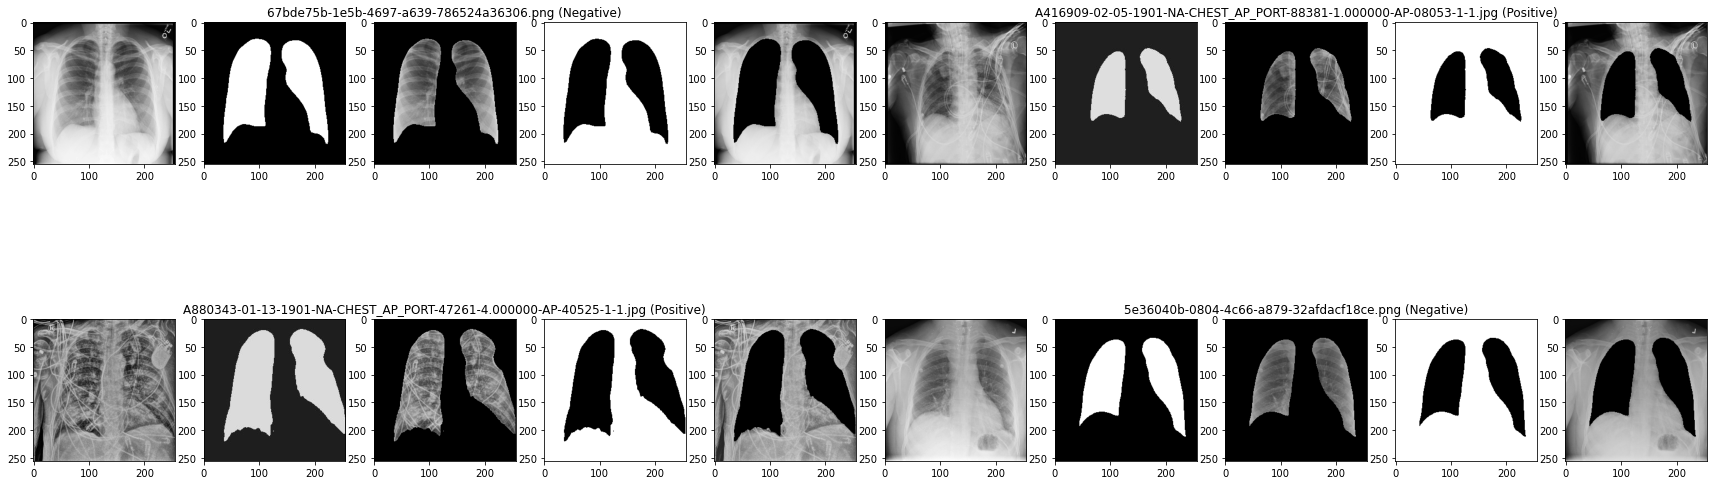

In [6]:
train_dataset = LungImageDataset(trainCrop_txt, '/mnt/DATA/research/project/classificationCOVID19applyseg/dataset/COVIDxCXR3/train/', '/mnt/DATA/research/project/classificationCOVID19applyseg/result/segmentation/lung_mask/', 256,True)
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle=True)

image, mask, maskthres, lung, cxrnotlung, targets, name = next(iter(train_dataloader))
# img_de_normalize (image, mask, mean, std)
# print(lung.shape)
# print(cxrnotlung.shape)
res1 = torch.transpose(lung,1,3)
# imshow_img_mask(img, mask, maskthres, lung, notlung, targets, name)

imshow_img_mask1(image, mask, maskthres, lung, cxrnotlung, targets, name, '/mnt/DATA/research/project/classificationCOVID19applyseg/result/classification/visualize/CXR_Lung_notLung.png')

In [7]:
def imshow_img_mask(img, mask, label):
    """ Imshow for Tensor """
    plt.figure(figsize = (30,10))
    for idx in range(3):
        label = ['Negative' if lb == 0 else 'Positive' for lb in targets]        

        plt.subplot(3,8, 1+idx*8)
        plt.imshow(img[4*idx], cmap='gray')
        plt.title(label[4*idx])
        plt.subplot(3,8, 2+idx*8)
        plt.imshow(mask[4*idx], cmap='gray')        

        plt.subplot(3,8,3+idx*8)
        plt.imshow(img[4*idx +1], cmap='gray')
        plt.title(label[4*idx+1])
        plt.subplot(3,8,4+idx*8)
        plt.imshow(mask[4*idx +1], cmap='gray')

        plt.subplot(3,8, 5+idx*8)
        plt.imshow(img[4*idx+2], cmap='gray')
        plt.title(label[4*idx+2])
        plt.subplot(3,8, 6+idx*8)
        plt.imshow(mask[4*idx+2], cmap='gray')

        plt.subplot(3,8, 7 +idx*8)
        plt.imshow(img[4*idx +3], cmap='gray')
        plt.title(label[4*idx+3])
        plt.subplot(3,8, 8 +idx*8)
        plt.imshow(mask[4*idx +3], cmap='gray')

    plt.savefig('../visualize/train_dataloader.png')

    plt.show()

In [8]:
train_dataset = LungImageDataset(train_txt, '/mnt/DATA/research/project/classificationCOVID19applyseg/dataset/COVIDxCXR3/train/', '/mnt/DATA/research/project/classificationCOVID19applyseg/result/segmentation/lung_mask/', size,True)
train_dataloader = DataLoader(train_dataset, batch_size = 12, shuffle=True)
image, mask, maskthres, lung, cxrnotlung, targets, name = next(iter(train_dataloader))
# imshow_img_mask(image, mask, name)

# 2. Split and Visualize Bad CXR + Lung

In [9]:
class DatasetPredict(Dataset):

    
    def __init__(self, img_folder,  transform = None): # 'Initialization'

        self.img_folder = img_folder
        self.transform = transform
  
    def __len__(self):  # 'Denotes the total number of samples'
        return len(os.listdir(self.img_folder))

    def __getitem__(self,index): # 'Generates one sample of data'      

        images_list = os.listdir(self.img_folder)
        # print(images_list)
        images_name = images_list[index]
        images = cv2.imread(self.img_folder +  images_name,0) # grey 
        # print(index)
        images = cv2.resize(images,(256,256))
        images = np.asanyarray(images, dtype=np.float32) # đoi qua numpy array kiểu float 32
        images = cv2.GaussianBlur(images, (3,3), cv2.BORDER_DEFAULT)    
        images = np.expand_dims(images,0).transpose(1,2,0) #### (256, 256, 1) 

        if self.transform != None:
            aug = self.transform(image = images)            
            images = aug['image']

        return images, images_name 

In [10]:
def save_filename(data, path):
        ################################
    # TAO FILE TXT LUU TEN ANH #####
    ################################
    list_name =[]
    # for _, name in tqdm(dataloaderPre(opt.batch_size, transfms)['Positive']):
    for _, name in tqdm(data):
        # print(name)
        list_name.append(name)

    res = []
    # for i in tqdm(range(len(list_name)-1)):
    for idx in range(len(list_name)):
        # print(i, idx, end= ' ')
        res.append(list_name[idx])
    # 
    # for i in range(len(list_name[len(list_name)-1])): #xu li phan le trong batch cuoi
    #     res.append(list_name[len(list_name)-1][i])

    # print('res: ',len(res))

    # np.savetxt('./visualize/FPN_DenseNet121/lung_mask/Positive/filenamePos.txt', res, fmt = '%s')
    np.savetxt(path, res, fmt = '%s')

data = DatasetPredict('/mnt/DATA/research/project/classificationCOVID19applyseg/dataset/COVIDxCXR3/EDA_Train/BadimgPositive/', transform = None)

loader = DataLoader(
        data, 
        batch_size=30,
        shuffle=False
        )

save_filename(data, '/mnt/DATA/research/project/classificationCOVID19applyseg/dataset/COVIDxCXR3/EDA_Train/BadImagefilename.txt')

100%|██████████| 43/43 [00:00<00:00, 124.32it/s]


In [11]:
bad_txt = pd.read_csv( '/mnt/DATA/research/project/classificationCOVID19applyseg/dataset/COVIDxCXR3/EDA_Train/BadImagefilename.txt', sep=' ', header=None)
bad_txt.columns=['file_name']
bad_txt.head()

,file_name
0,A766547-01-05-1901-NA-CHEST_AP_PORT-20642-3.00...
1,A494186-01-14-1901-NA-CHEST_AP_PORTABLE-44693-...
2,A056642-12-31-1900-NA-CHEST_AP_PORT-26394-4.00...
3,A281009-02-01-1901-NA-CHEST_AP_PORT-62357-1.00...
4,A462317-01-01-1901-NA-CHEST_AP_PORT_CENTRAL_LI...


In [12]:
bad_txt['label'] = 'Positive'
bad_txt

,file_name,label
0,A766547-01-05-1901-NA-CHEST_AP_PORT-20642-3.00...,Positive
1,A494186-01-14-1901-NA-CHEST_AP_PORTABLE-44693-...,Positive
2,A056642-12-31-1900-NA-CHEST_AP_PORT-26394-4.00...,Positive
3,A281009-02-01-1901-NA-CHEST_AP_PORT-62357-1.00...,Positive
4,A462317-01-01-1901-NA-CHEST_AP_PORT_CENTRAL_LI...,Positive
5,A536707-01-06-1901-NA-CHEST_AP_PORT-00467-5.00...,Positive
6,A358591-02-06-1901-NA-CHEST_AP_PORT_CENTRAL_LI...,Positive
7,A281009-02-01-1901-NA-CHEST_AP_PORT-62357-6.00...,Positive
8,A653181-01-31-1901-NA-CHEST_AP_PORT-70039-2.00...,Positive
9,A587516-12-31-1900-NA-CHEST_AP_VIEWONLY-00217-...,Positive


In [13]:
class BadDataset(Dataset): # train tren Lung

    
    def __init__(self,csv, img_folder, mask_folder): # 'Initialization'
        self.csv=csv
        self.img_folder=img_folder
        self.mask_folder = mask_folder
    
        self.image_names=self.csv[:]['file_name']# [:] lấy hết số cột số hàng của bảng
        self.labels= np.array(self.csv[:]['label']) # note kiểu mảng int đúng không?
  
    def __len__(self):  # 'Denotes the total number of samples'
        return len(self.image_names)

    def __getitem__(self,index): # 'Generates one sample of data'
    
        image=cv2.imread(self.img_folder + self.image_names.iloc[index], 0)
        image = cv2.resize(image,(256,256))

        mask = cv2.imread(self.mask_folder + self.image_names.iloc[index], 0)
        mask = cv2.resize(mask,(256,256))


        name = self.image_names[index]
        label1 =self.labels[index]
        # label1 = torch.tensor(int(label1), dtype=torch.long) #đọc từng phần tử của mảng, chuyển từ array -> tensor; kiểu int64 tương ứng với long trong pytorch

        return image, mask, name, label1 

In [19]:
def imshow_img_mask1(img, mask, label):
    """ Imshow for Tensor"""
    plt.figure(figsize = (36,20))
    for idx in range(6):
        # label = ['Negative' if lb == 0 else 'Positive' for lb in targets]        

        plt.subplot(6,14, 1+idx*14)
        plt.imshow(img[7*idx], cmap='gray')
        plt.title(label[7*idx])
        plt.subplot(6,14, 2+idx*14)
        plt.imshow(mask[7*idx], cmap='gray')        

        plt.subplot(6,14,3+idx*14)
        plt.imshow(img[7*idx +1], cmap='gray')
        plt.title(label[7*idx+1])
        plt.subplot(6,14,4+idx*14)
        plt.imshow(mask[7*idx +1], cmap='gray')

        plt.subplot(6,14, 5+idx*14)
        plt.imshow(img[7*idx+2], cmap='gray')
        plt.title(label[7*idx+2])
        plt.subplot(6,14, 6+idx*14)
        plt.imshow(mask[7*idx+2], cmap='gray')

        plt.subplot(6,14, 7 +idx*14)
        plt.imshow(img[7*idx +3], cmap='gray')
        plt.title(label[7*idx+3])
        plt.subplot(6,14, 8 +idx*14)
        plt.imshow(mask[7*idx +3], cmap='gray')

        plt.subplot(6,14, 9 +idx*14)
        plt.imshow(img[7*idx +4], cmap='gray')
        plt.title(label[7*idx+4])
        plt.subplot(6,14, 10 +idx*14)
        plt.imshow(mask[7*idx +4], cmap='gray')

        plt.subplot(6,14, 9 +idx*14)
        plt.imshow(img[7*idx +5], cmap='gray')
        plt.title(label[7*idx+5])
        plt.subplot(6,14, 10 +idx*14)
        plt.imshow(mask[7*idx +5], cmap='gray')

        plt.subplot(6,14, 9 +idx*14)
        plt.imshow(img[7*idx +6], cmap='gray')
        plt.title(label[7*idx+6])
        plt.subplot(6,14, 10 +idx*14)
        plt.imshow(mask[7*idx +6], cmap='gray')

    plt.savefig('/mnt/DATA/research/project/classificationCOVID19applyseg/result/classification/visualize/Baddata.png')

    plt.show()

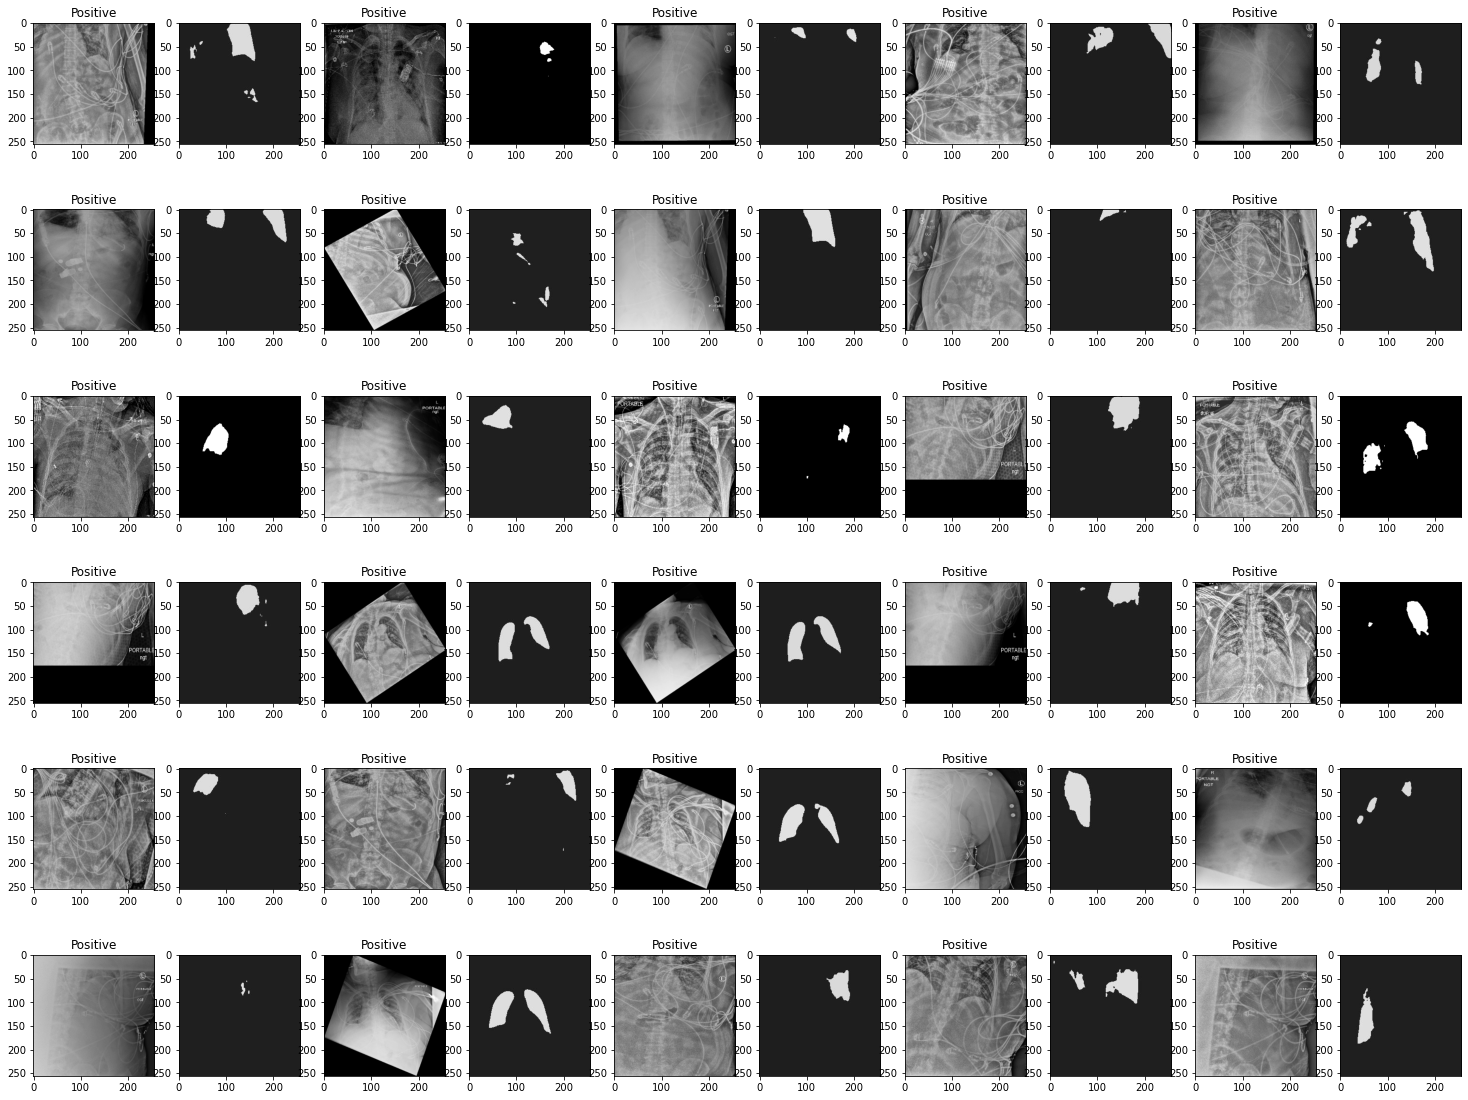

In [20]:
bad_dataset = BadDataset(bad_txt, '/mnt/DATA/research/project/classificationCOVID19applyseg/dataset/COVIDxCXR3/EDA_Train/BadimgPositive/', '/mnt/DATA/research/project/classificationCOVID19applyseg/dataset/COVIDxCXR3/EDA_Train/BadmaskPositive/')
bad_dataloader = DataLoader(bad_dataset, batch_size = 43, shuffle=True)
image, mask, name, label1  = next(iter(bad_dataloader))
imshow_img_mask1(image, mask, label1)

In [16]:
bad_dataset = LungImageDataset(train_txt, '/mnt/DATA/covid19_resnet152_python-main/archive_14gb/COVIDxCXR3/train/', '/mnt/DATA/covid19_resnet152_python-main/archive_14gb/mainscript/segment/visualize/FPN_DenseNet121/lung_mask/', True, False)
train_dataloader = DataLoader(bad_dataset, batch_size = 12, shuffle=True)
image, mask, maskthres, lung, cxrnotlung, targets, name = next(iter(train_dataloader))
imshow_img_mask(image, mask, name)

[ WARN:0@8.142] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/mnt/DATA/covid19_resnet152_python-main/archive_14gb/COVIDxCXR3/train/efaf2c2a-ea1b-4963-b431-16dcd36f9fa3.png'): can't open/read file: check file path/integrity
[ WARN:0@8.143] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/mnt/DATA/covid19_resnet152_python-main/archive_14gb/mainscript/segment/visualize/FPN_DenseNet121/lung_mask/EDA_Test/Negative/efaf2c2a-ea1b-4963-b431-16dcd36f9fa3.png'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Sequence item with index 0 has a wrong type
>  - Can't parse 'dsize'. Sequence item with index 0 has a wrong type
